# 1 Anomaly detection 
Implement an anomaly detection algorithm to detect anomalous behavior in server computers.
Use a Gaussian model to detect anomalous examples in the dataset.

In [1]:
import scipy.io # load .mat file
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load file 
data = scipy.io.loadmat('data/ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
X[:5]

array([[13.04681517, 14.74115241],
       [13.40852019, 13.7632696 ],
       [14.19591481, 15.85318113],
       [14.91470077, 16.17425987],
       [13.57669961, 14.04284944]])

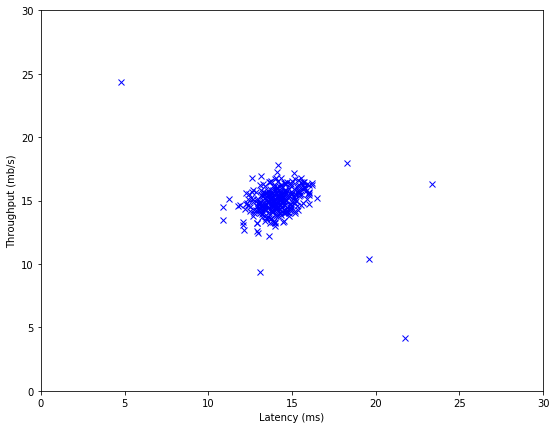

In [3]:
def plotData():
    plt.figure(figsize=(9,7))
    plt.plot(X[:,0], X[:,1], 'bx')
    plt.xlim((0,30))
    plt.ylim((0,30))
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')

plotData()

## 1.1 Gaussian distribution 
To perform anomaly detection, fit a model to the data’s distribution first.
Assume a Gaussian distribution for the dataset.

In [4]:
def multivariateGaussian(X, mu, Sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    """
    Sigma2 = np.diagflat(Sigma2)     # transform into a diagoanl matrix
    Sig2_rec = np.linalg.inv(Sigma2) # the diagonals of the inverse matrix of a diagonal matrix are its reciprocals
    part1 = 1/(2*np.pi * np.linalg.det(Sig2_rec)**(1/2))# determinant of a diag matrix is the product of its diagonals
    part2 = ((X - mu)**2).dot(Sig2_rec)                 
    p = part1*np.exp(-(1/2)*np.sum(part2,axis=1))
    return np.c_[p]

## 1.2 Estimating parameters for a Gaussian 

In [5]:
def estimateGaussian(X):
    """
    estimates the parameters of a Gaussian distribution using the data in X
    """
    m,n = X.shape
    mu = np.mean(X, axis=0)    
    sigma2 = np.var(X, axis=0)  # trun it into a column vector
    return mu, sigma2

In [6]:
def visualizeFit(X, mu, sigma2):
    """
    This visualization shows you the probability density function of the Gaussian distribution. 
    Each example has a location (x1, x2) that depends on its feature values.
    """
    x1, x2 = np.arange(0,30,.5), np.arange(0,30,.5)
    xx, yy = np.meshgrid(x1, x2)
    z = np.c_[xx.flatten(), yy.flatten()]
    zz = multivariateGaussian(z, mu, sigma2)
    zz = zz.reshape(x1.shape[0], x1.shape[0])
    
    plotData()
    _levels = [10**power for power in range(-20,0,3)]
    plt.contour(xx, yy, zz, levels=_levels)

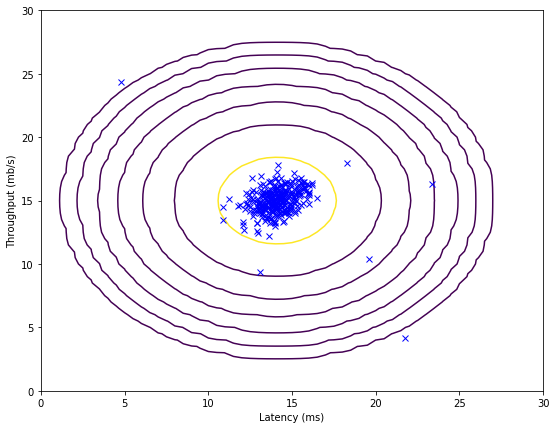

In [7]:
mu, sigma2 = estimateGaussian(X)
visualizeFit(X, mu, sigma2)

## 1.3 Selecting the threshold, ε 
Given the estimated Gaussian distribution, 
find a good epsilon threshold ε using a cross-validation set probabilities 

In [8]:
pval = multivariateGaussian(Xval, mu, sigma2)
pval[:5] 

array([[0.13044713],
       [0.25664821],
       [0.12757609],
       [0.19395341],
       [0.22305181]])

In [9]:
def selectThreshold(yval, pval):
    """
    Compute the F1 score based on the results from a validation set (pval) and the truth (yval)
    record the bestF1 and bestEpsilon  
    """
    bestEpsilon, bestF1, F1 = 0, 0, 0
    for epsilon in np.linspace(min(pval), max(pval), 1000):
        predictions = (pval < epsilon)
        tp = sum(((predictions == 1) & (yval == 1)).flatten())
        fp = sum(((predictions == 1) & (yval == 0)).flatten())
        fn = sum(((predictions == 0) & (yval == 1)).flatten())
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
        F1 = 2*prec*rec/(prec+rec)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = float(epsilon)
    return bestEpsilon, bestF1

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: {:.3}'.format(epsilon))
print('Best F1 on Cross Validation Set: {:.3}'.format(F1))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


Best epsilon found using cross-validation: 0.000282
Best F1 on Cross Validation Set: 0.875


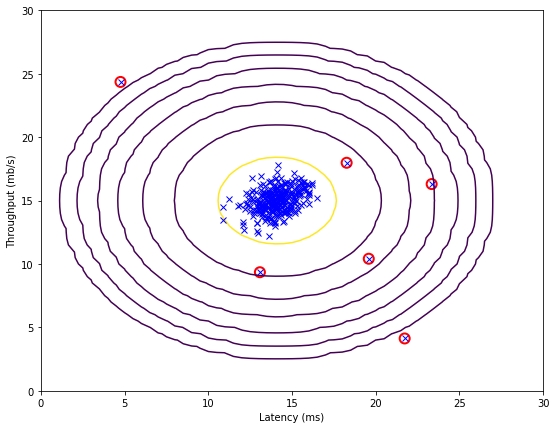

In [10]:
# Find the outliers in the training set and plot 
p = multivariateGaussian(X, mu, sigma2)
outliers = (p < epsilon).flatten()

# Draw a red circle around those outliers
visualizeFit(X, mu, sigma2)
plt.scatter(X[outliers,0], X[outliers,1], s=100, linewidths=2, facecolors='none', edgecolors='r')
plt.show()

## 1.4 High dimensional dataset 

In [11]:
# load file 
data = scipy.io.loadmat('data/ex8data2.mat')
X, Xval, yval = data['X'], data['Xval'], data['yval']

# Apply the same steps to the larger dataset
mu,sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
outliers = sum((p < epsilon).flatten())

print('Best epsilon found using cross-validation: {}'.format(epsilon))
print('Best F1 on Cross Validation Set: {:.6}'.format(F1))
print('# Outliers found: {}'.format(outliers))

Best epsilon found using cross-validation: 258525.97368064328
Best F1 on Cross Validation Set: 0.615385
# Outliers found: 117


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
